In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")
#loads data from the original source on the web 

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [40]:


named_data <- data %>%
    rename(
        absolute_title_subjectivity = abs_title_subjectivity,
        title_length = n_tokens_title,
        absolute_title_sentiment_polarity = abs_title_sentiment_polarity,
        meta_tags = num_keywords
    )

#wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis

In [5]:
tidy_data <- named_data %>%
    select(title_length, meta_tags, title_subjectivity,absolute_title_subjectivity,title_sentiment_polarity,absolute_title_sentiment_polarity, shares)



In [6]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.75, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)


title_length,meta_tags,title_subjectivity,absolute_title_subjectivity,title_sentiment_polarity,absolute_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,5,0.5000000,0.0000000,-0.1875000,0.1875000,593
9,4,0.0000000,0.5000000,0.0000000,0.0000000,711
9,7,0.0000000,0.5000000,0.0000000,0.0000000,1200
10,9,0.6428571,0.1428571,0.2142857,0.2142857,855
12,9,1.0000000,0.5000000,0.5000000,0.5000000,891
11,7,0.1250000,0.3750000,0.0000000,0.0000000,3600


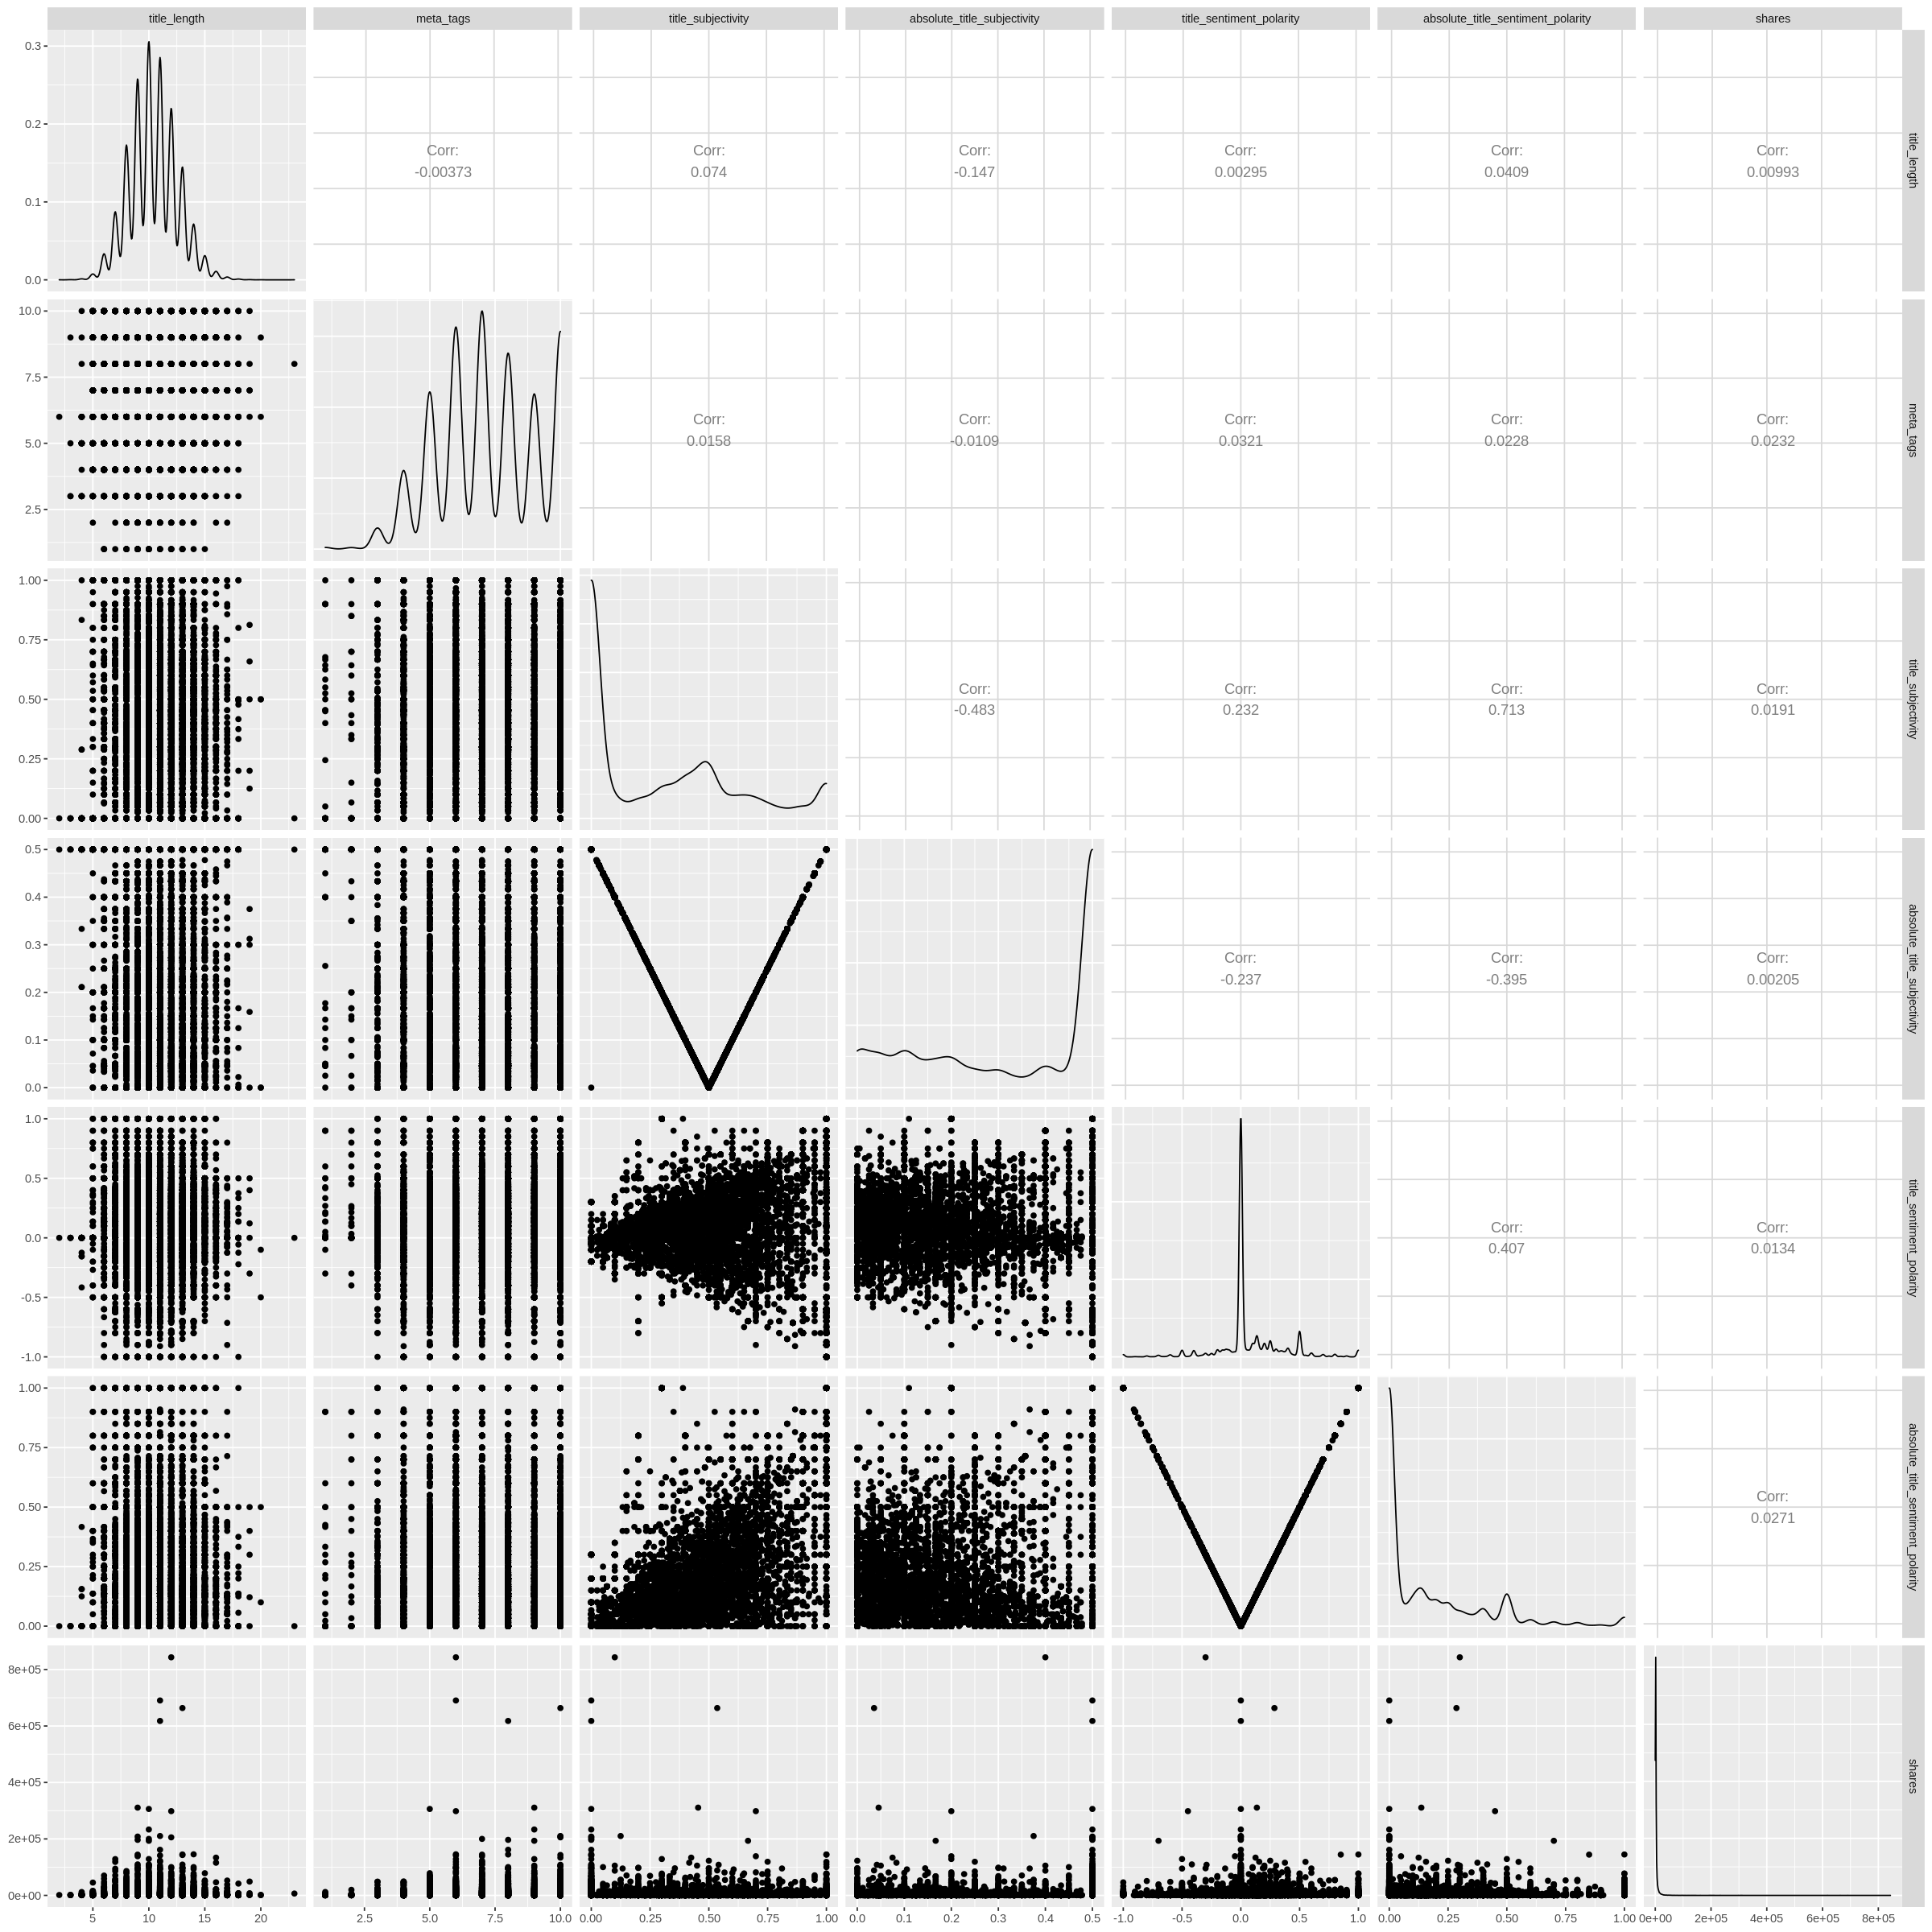

In [9]:
options(repr.plot.width = 20, repr.plot.height = 20)

pairs <- publishing_train %>%
    ggpairs()
pairs

#performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
#creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

In [10]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 


share_recipe <- recipe(shares ~ title_length+absolute_title_sentiment_polarity+meta_tags, data = publishing_train) %>%
       step_scale(-shares) %>%
       step_center(-shares)

In [13]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)

share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 25:500) %>%
    filter(neighbors %% 25 == 0 )

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

head(share_results)
#performs the data analysis

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,rmse,standard,1.182540e+04,5,7.865335e+02,Model01
25,rsq,standard,1.699059e-04,5,9.967990e-05,Model01
50,rmse,standard,1.167699e+04,5,8.590718e+02,Model02
50,rsq,standard,7.717900e-05,5,6.352756e-05,Model02
75,rmse,standard,1.158300e+04,5,8.502256e+02,Model03
75,rsq,standard,6.582332e-05,5,3.764870e-05,Model03


In [14]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
475,rmse,standard,11469.37,5,857.7639,Model19


In [17]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)

share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

share_summary <- share_preds %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.173882e+04
rsq,standard,4.980522e-04
mae,standard,3.252393e+03


In [18]:
lm_rmspe <- share_summary %>%
          filter(.metric == "rmse") %>%
          select(.estimate) %>%
          pull()

std_dev <- pull(summarize(publishing_test, sd(shares)))
mean <- pull(summarize(publishing_test, mean(shares)))


print(paste("RMSPE: ", lm_rmspe, sep=""))

print(paste("Standard deviation: ", std_dev, sep=""))


#creates a visualization of the analysis 

[1] "RMSPE: 11738.8229294369"
[1] "Standard deviation: 11736.0111107009"


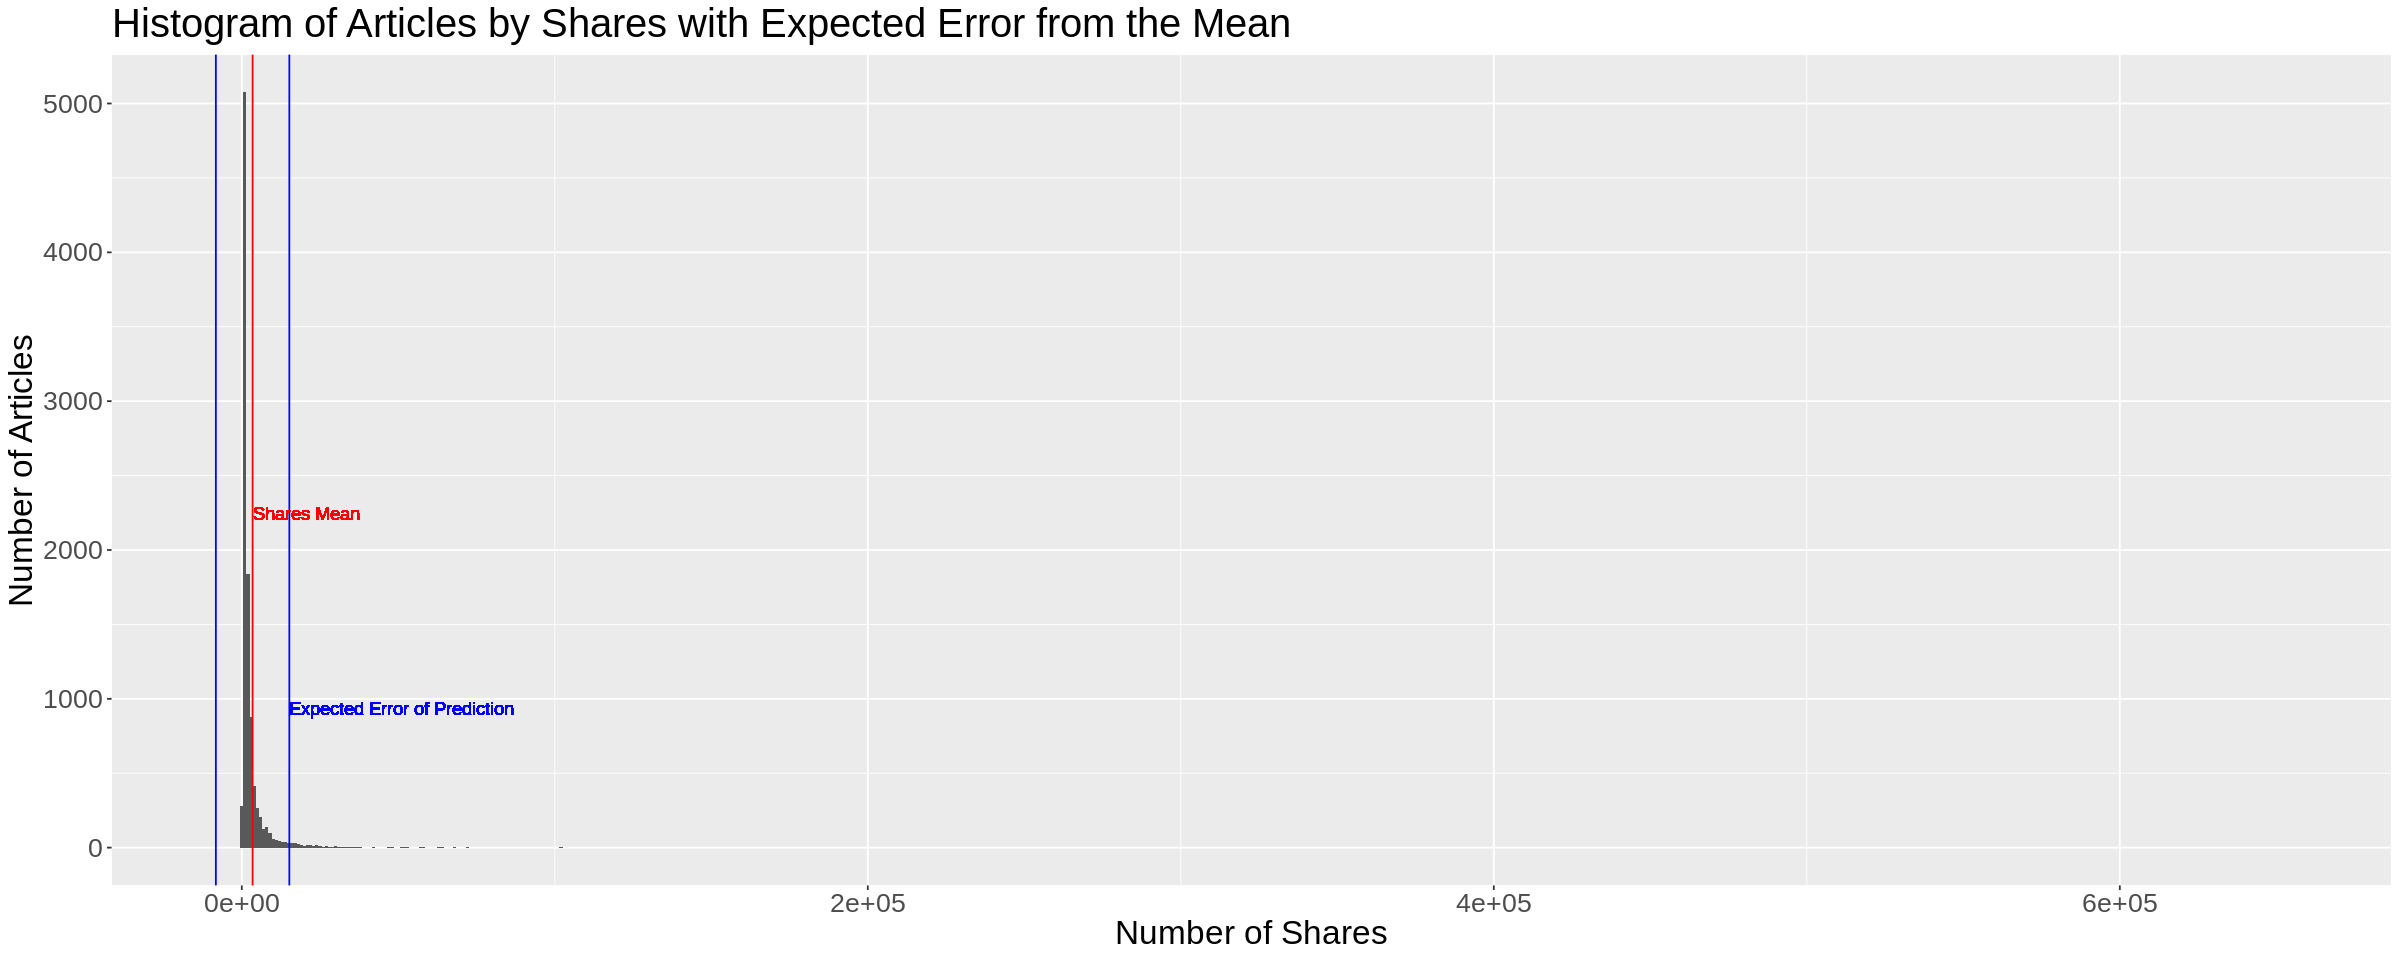

In [66]:
line.data <- data.frame(xintercept = c(mean+lm_rmspe, mean-lm_rmspe,mean ), Lines = c("Expected Prediction Error", "Expected Prediction Error", "Testing Data Mean"),
  color = c("blue", "blue", "red"), stringsAsFactors = FALSE)


options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(publishing_test, aes(x=shares)) +
    geom_histogram(binwidth=1000)+
    geom_vline(aes(xintercept=mean+lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean-lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean),color="red")+
    geom_text(aes(x=mean+lm_rmspe, label="Expected Error of Prediction", y=20), colour="blue", angle=0, vjust = -10, hjust = 0)+
    geom_text(aes(x=mean, label="Shares Mean", y=20), colour="red", angle=0, hjust = 0, vjust = -25)+
    labs(x="Number of Shares",y="Number of Articles", title="Histogram of Articles by Shares with Expected Error from the Mean")+
    theme(text = element_text(size = 20))




In [67]:
options(repr.plot.width = 8, repr.plot.height = 8)


title_length_plot <- ggplot(publishing_test, aes(x = title_length, y = shares)) +
  geom_point(alpha = 0.2) +
  labs(x="Length of the Article Title",y="Shares")+
  geom_line(data = share_preds, aes(x = title_length, y = .pred), color = "blue")+
  ggtitle("Shares by Title Length with Predictions")+
  theme(text = element_text(size = 20))

In [71]:
metadata_plot <- ggplot(publishing_test, aes(x = meta_tags, y = shares)) +
  geom_point(alpha = 0.2) +
  labs(x="Length of the Article Title",y="Shares")+
  geom_line(data = share_preds, aes(x = meta_tags, y = .pred), color = "blue")+
  ggtitle("Shares by Metadata Tags with Predictions")+
  theme(text = element_text(size = 20))

In [72]:
title_polarity_plot <- ggplot(publishing_test, aes(x = absolute_title_sentiment_polarity, y = shares)) +
  geom_point(alpha = 0.2) +
  labs(x="Absolute Title Polarity", y="Shares")+
  geom_line(data = share_preds, aes(x = absolute_title_sentiment_polarity, y = .pred), color = "blue")+
  ggtitle("Shares by Title Polarity with Predictions")+
  theme(text = element_text(size = 20))

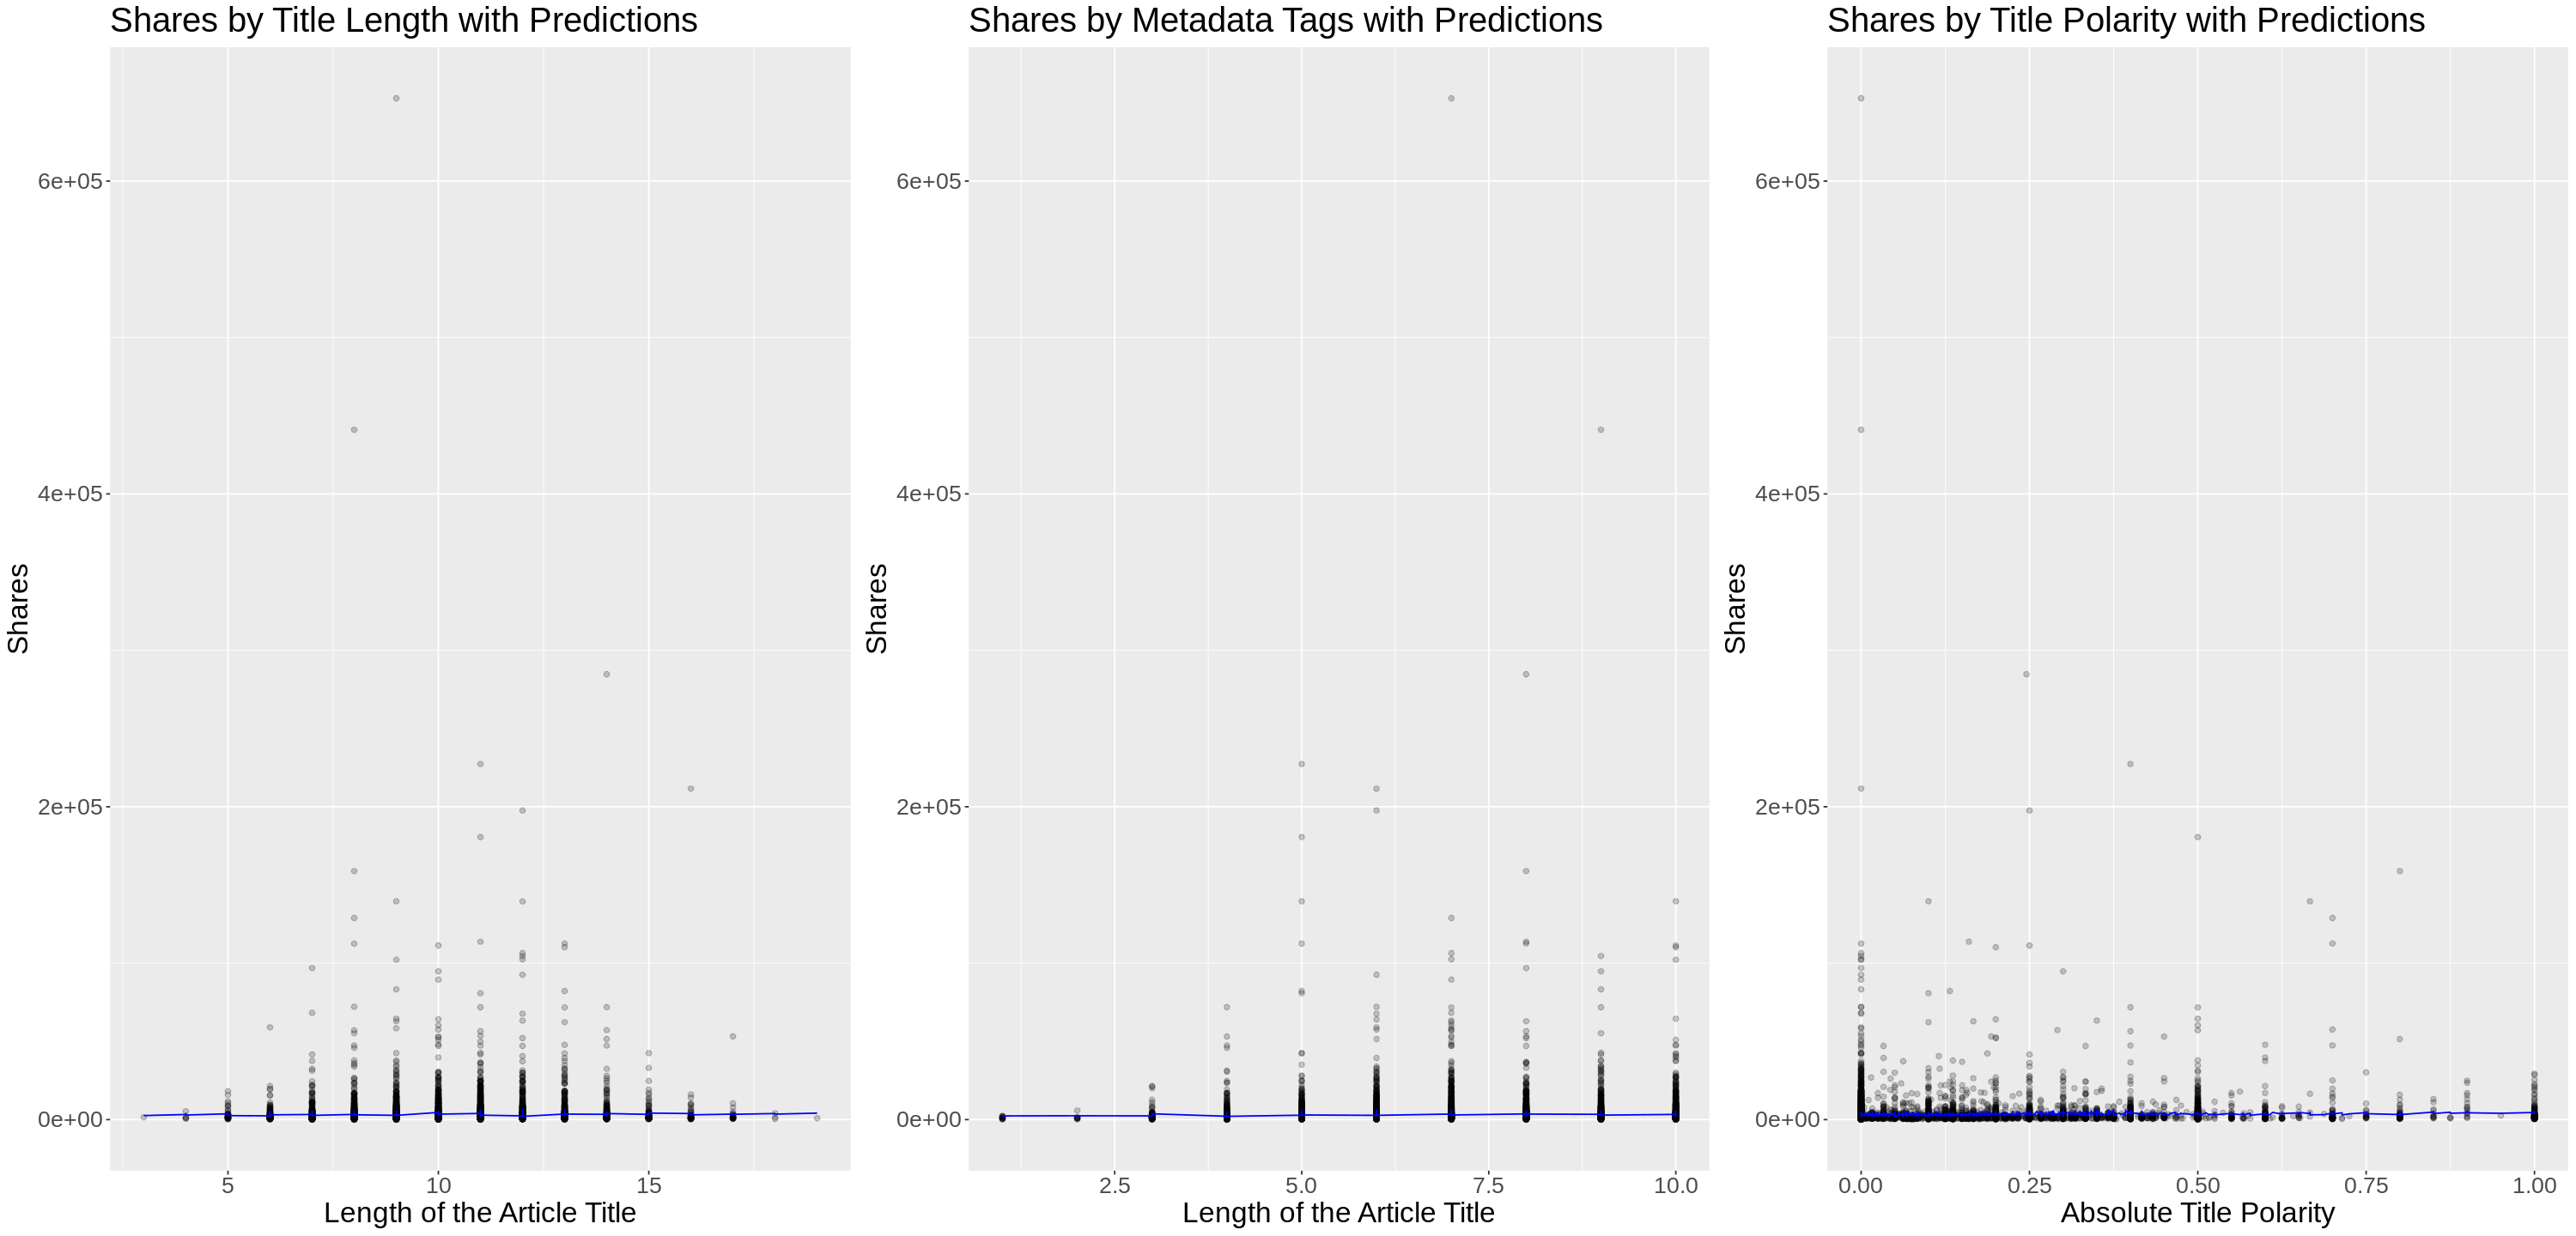

In [74]:
options(repr.plot.width = 25, repr.plot.height = 12)

plot_grid(title_length_plot,
                   metadata_plot,
                   title_polarity_plot,
                   ncol = 3)

In [39]:
explore_data <- named_data %>%
    mutate (Popular = shares > 1500)%>%
    mutate(Popular = as_factor(Popular)) %>%
    select(-url, -timedelta)
head(explore_data)
explore_data %>%
    group_by(Popular) %>%
    summarize(n=n()) %>%
    select(Popular, n)

title_length,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,⋯,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,absolute_title_subjectivity,absolute_title_sentiment_polarity,shares,Popular
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,⋯,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593,FALSE
9,255,0.6047431,1,0.7919463,3,1,1,0,4.913725,⋯,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711,FALSE
9,211,0.5751295,1,0.6638655,3,1,1,0,4.393365,⋯,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500,FALSE
9,531,0.5037879,1,0.6656347,9,0,1,0,4.404896,⋯,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200,FALSE
13,1072,0.4156456,1,0.5408895,19,19,20,0,4.682836,⋯,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505,FALSE
10,370,0.5598886,1,0.6981982,2,2,0,0,4.359459,⋯,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855,FALSE


`summarise()` ungrouping output (override with `.groups` argument)



Popular,n
<fct>,<int>
FALSE,21405
TRUE,18239


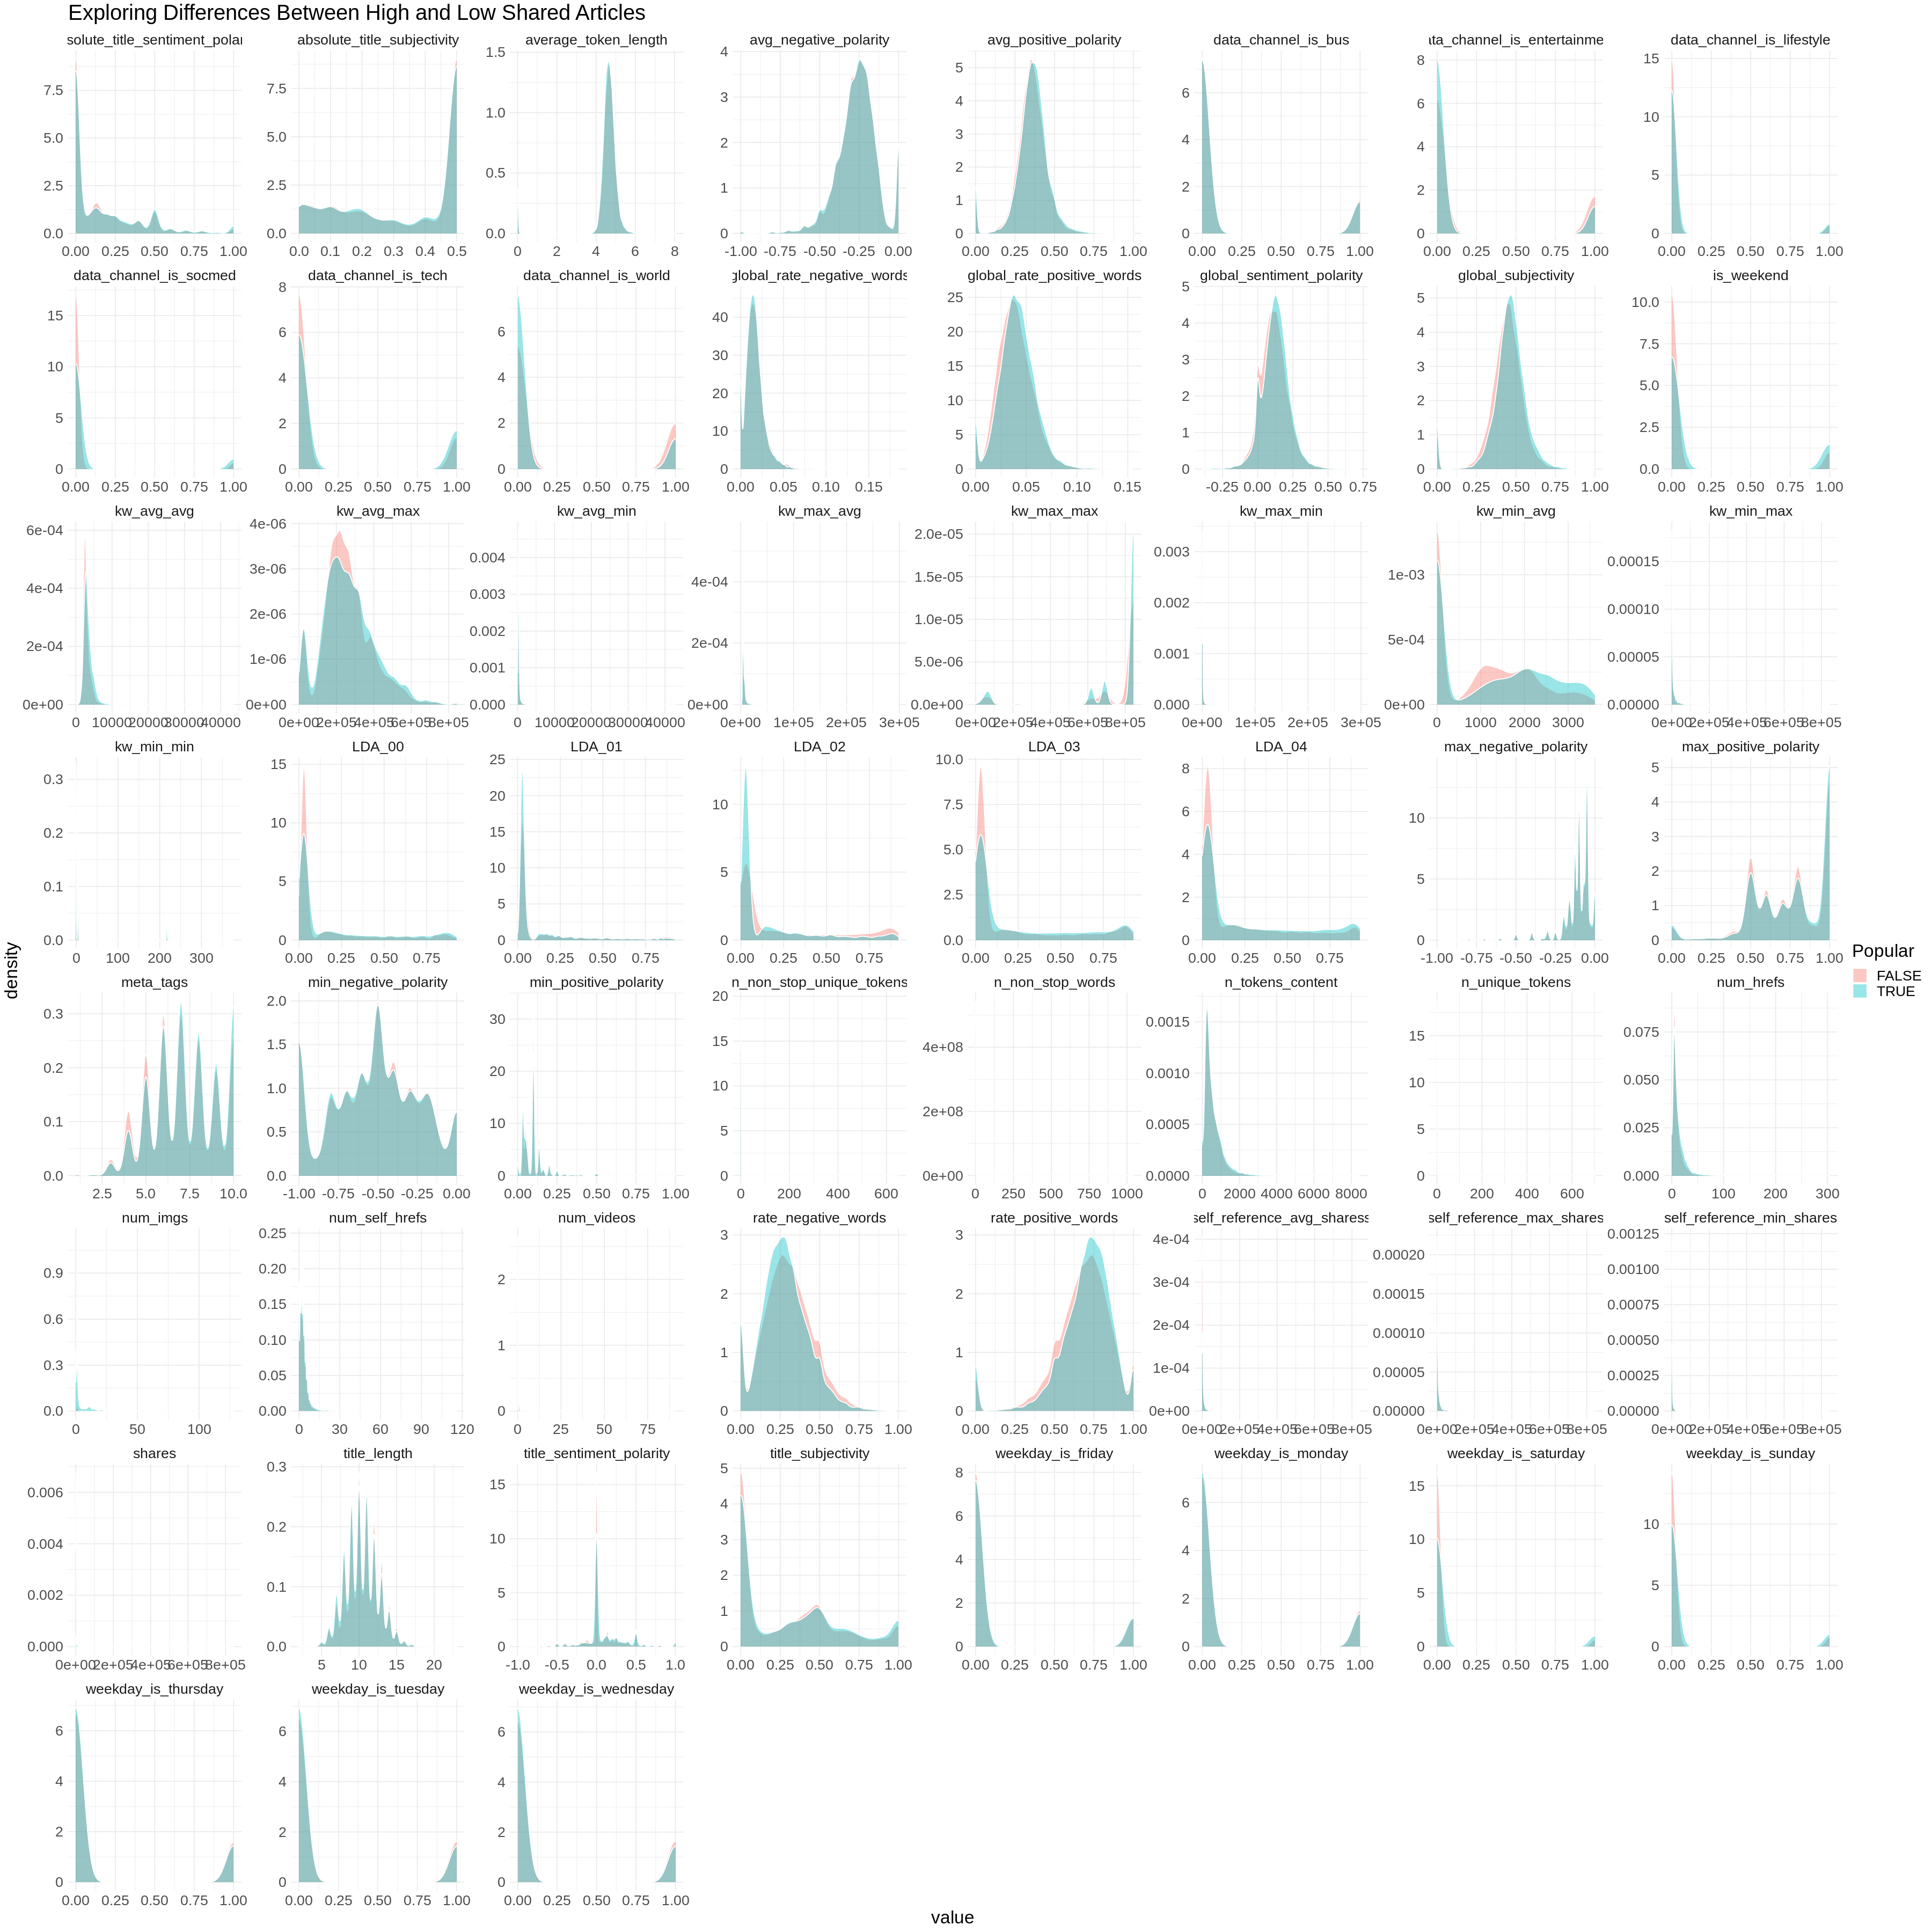

In [42]:
options(repr.plot.height = 30, repr.plot.width = 30)
explore_data %>%
    pivot_longer(cols = -Popular, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = Popular)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))+
        ggtitle("Exploring Differences Between High and Low Shared Articles")